
# Latent Dirichlet Allocation(LDA) for 'Customer interest' modelling


#### Import libraries

In [1]:
# !pip install pyLDAvis 

In [2]:
# import libraries 
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
import gensim
from gensim import corpora

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


####   Dataset Analysis

In [4]:
# Read data from csv
customer_review_data= pd.read_csv("E:\\code\\SENETIMENT_ANALYSIS_AMAZON\\LDACustomerInterviewsModelling\\amazon_alexa - amazon_alexa.csv")
print(customer_review_data.head(2))
print(len(customer_review_data))
print('Number of Unique variation')
print(len(customer_review_data.groupby('variation')))

   rating       date        variation verified_reviews  feedback
0       5  31-Jul-18  Charcoal Fabric    Love my Echo!         1
1       5  31-Jul-18  Charcoal Fabric        Loved it!         1
3150
Number of Unique variation
16


In [5]:
# Clean text
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    return text2.lower()

In [6]:
# In natural language processing, useless words (data), are referred to as stop words. 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Removes the rows that contains NULL values.
customer_review_data.dropna(axis = 0, how ='any',inplace=True) 

####   Filter short reviews according to rating

In [8]:
customer_review_data['verified_reviews'] = customer_review_data['verified_reviews'].apply(clean_text)
customer_review_data['Num_words_text'] = customer_review_data['verified_reviews'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(customer_review_data['rating'].value_counts())
print(len(customer_review_data))
print('-------------------------')
max_review_data_sentence_length  = customer_review_data['Num_words_text'].max()

mask = (customer_review_data['Num_words_text'] < 100) & (customer_review_data['Num_words_text'] >=20)
df_short_reviews = customer_review_data[mask]
df_new = df_short_reviews.groupby('rating').apply(lambda x: x.sample(n=40)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    2246
4     447
1     146
3     140
2      92
Name: rating, dtype: int64
3071
-------------------------
No of Short reviews
640


In [9]:
df_short_reviews

,rating,date,variation,verified_reviews,feedback,Num_words_text
2,4,31-Jul-18,Walnut Finish,sometimes while playing game answer question c...,1,21
6,3,31-Jul-18,Sandstone Fabric,without having cellphone cannot many features ...,1,33
7,5,31-Jul-18,Charcoal Fabric,think this purchased working getting every roo...,1,22
12,5,30-Jul-18,Oak Finish,purchased this mother having knee problems giv...,1,30
17,5,30-Jul-18,Heather Gray Fabric,have only been using alexa couple days having ...,1,21
...,...,...,...,...,...,...
3101,5,30-Jul-18,Black Dot,these additional alexa based devices make acce...,1,27
3110,5,30-Jul-18,White Dot,love personally prefer spotify music it’s grea...,1,46
3129,4,30-Jul-18,White Dot,have these throughout home they great there ti...,1,38
3147,5,30-Jul-18,Black Dot,love these things have them running entire hom...,1,49


In [10]:
df_new

,rating,date,variation,verified_reviews,feedback,Num_words_text
0,1,14-Jul-18,White Plus,will returning this piece garbage soon possibl...,0,76
1,1,17-Jul-18,Black Spot,bought spot loved within months started acting...,0,62
2,1,26-Jul-18,Black Plus,disappointed this product tried install differ...,0,45
3,1,29-Jul-18,Black Show,returned from repair with repair done problem ...,0,34
4,1,24-Jul-18,Black,never could work techie friend looked said ada...,0,25
...,...,...,...,...,...,...
195,5,31-Jul-18,Configuration: Fire TV Stick,ideal when have amazon prime very first fire s...,1,22
196,5,31-Jul-18,Configuration: Fire TV Stick,love fire stick download watch great movies in...,1,28
197,5,24-Jul-18,White Spot,easily impressed with electronic goodies butom...,1,69
198,5,30-Jul-18,Heather Gray Fabric,little nervous when received echo really tech ...,1,23


####   Dataset Pre-processing

In [11]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_new['verified_reviews']=df_new['verified_reviews'].apply(remove_stopwords)

In [12]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
# create a lemmatization for filtering
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.g

#### Finding Nouns and Adjectives

In [13]:
text_list=df_new['verified_reviews'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

bought spot loved within months started acting funny would stop working—called determined overheating told unplug technical support would call within hours waited hours without response replied email asked wait week week goes absolutely response inline chat instructions told wait longer really unacceptable—expected amazon find funny always thank prime member issue arises cannot even assistance
['spot', 'month', 'determined', 'technical', 'support', 'hour', 'hour', 'response', 'email', 'week', 'week', 'response', 'chat', 'instruction', 'unacceptable', 'funny', 'prime', 'member', 'issue']


#### Dictionary and Document term matrix

In [14]:
# Create vocabulary dictionary and document term matrix
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

####  LDA model

In [15]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [16]:
# Build LDA model
num_topics=34
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=10,
                chunksize=1000, passes=50,iterations=100)

In [17]:
lda_model.print_topics(num_topics)

[(0,
  '0.051*"product" + 0.026*"control" + 0.026*"program" + 0.026*"time" + 0.013*"value" + 0.013*"voice" + 0.013*"sure" + 0.013*"switch" + 0.013*"thousand" + 0.013*"customer"'),
 (1,
  '0.085*"device" + 0.036*"echo" + 0.022*"music" + 0.022*"able" + 0.022*"movie" + 0.014*"stick" + 0.014*"problem" + 0.014*"many" + 0.014*"download" + 0.014*"connect"'),
 (2,
  '0.044*"time" + 0.044*"alexa" + 0.044*"component" + 0.037*"music" + 0.029*"fio" + 0.029*"radio" + 0.029*"great" + 0.029*"control" + 0.015*"news" + 0.015*"weather"'),
 (3,
  '0.028*"sling" + 0.028*"fault" + 0.028*"checking" + 0.028*"speaker" + 0.028*"company" + 0.028*"boom" + 0.028*"alexa" + 0.028*"rechargeable" + 0.028*"socket" + 0.028*"plugin"'),
 (4,
  '0.046*"music" + 0.028*"device" + 0.028*"great" + 0.028*"daughter" + 0.019*"issue" + 0.019*"product" + 0.019*"service" + 0.019*"full" + 0.019*"connection" + 0.019*"show"'),
 (5,
  '0.022*"reception" + 0.022*"poor" + 0.022*"work" + 0.022*"command" + 0.022*"unit" + 0.018*"good" + 0.0

#### Measureing the model

In [18]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=100))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)



Perplexity:  -8.995979068207966

Coherence Score: 0.45357895885287974


#### Visualize the topics

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.117609  0.006403       1        1  10.094949
24    -0.160406 -0.036697       2        1   7.037576
20    -0.066246 -0.074411       3        1   5.531841
7     -0.086127  0.001694       4        1   5.276335
32    -0.119739 -0.071860       5        1   5.108992
26    -0.109104  0.080973       6        1   4.982945
23    -0.047868 -0.080422       7        1   4.876414
18    -0.096775 -0.056605       8        1   4.705058
17    -0.121164 -0.030017       9        1   4.024761
27    -0.051733 -0.007872      10        1   3.444781
1     -0.076098  0.107969      11        1   3.383879
2      0.054110 -0.191775      12        1   3.349854
15    -0.067267  0.043557      13        1   3.298649
12    -0.011369  0.022392      14        1   3.256017
21     0.083396  0.003344      15        1   3.168654
31    -0.037624  0.008549      16        1   2.919197
19     0.010403  0.124079      17        1   2.438275
4     -0.062005  0.001955      18        1   2.416031
5      0.108796  0.054727      19        1   1.975380
29     0.031808  0.035371      20        1   1.856570
16    -0.000791  0.097454      21        1   1.781465
25     0.021343  0.070704      22        1   1.714295
0      0.061687 -0.030778      23        1   1.586582
30     0.038127  0.089193      24        1   1.489519
3      0.091265 -0.052018      25        1   1.424688
9      0.113370 -0.037524      26        1   1.332371
8      0.051615 -0.021574      27        1   1.211562
10     0.047849 -0.037515      28        1   1.119702
14     0.045924 -0.068934      29        1   1.064311
11     0.096545 -0.013404      30        1   0.991109
33     0.105214 -0.042572      31        1   0.873080
28     0.074505  0.112565      32        1   0.856861
22     0.078727 -0.022240      33        1   0.751780
13     0.117242  0.015289      34        1   0.656516, topic_info=         Term       Freq      Total Category  logprob  loglift
81     device  71.000000  71.000000  Default   30.000  30.0000
104     music  64.000000  64.000000  Default   29.000  29.0000
140      work  24.000000  24.000000  Default   28.000  28.0000
299     video  18.000000  18.000000  Default   27.000  27.0000
36       spot  15.000000  15.000000  Default   26.000  26.0000
..        ...        ...        ...      ...      ...      ...
14   possible   0.013769   2.185763  Topic34   -7.354  -0.0413
15    product   0.013769  27.557974  Topic34   -7.354  -2.5756
16     rarity   0.013769   1.372434  Topic34   -7.354   0.4241
17      small   0.013769   7.984030  Topic34   -7.354  -1.3368
18   spending   0.013769   1.372434  Topic34   -7.354   0.4241

[1617 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
613      21  0.721931    342nd
97        5  0.832955     34im
269      15  0.878514    34the
331       4  0.640662  34thing
236       4  0.830058    34try
...     ...       ...      ...
307      16  0.252113  youtube
307      17  0.126056  youtube
24       23  0.728633   zigbee
563      19  0.706594    zwave
370      10  0.665317     zzzz

[2059 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 25, 21, 8, 33, 27, 24, 19, 18, 28, 2, 3, 16, 13, 22, 32, 20, 5, 6, 30, 17, 26, 1, 31, 4, 10, 9, 11, 15, 12, 34, 29, 23, 14])

#### Finding the best model 

In [20]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

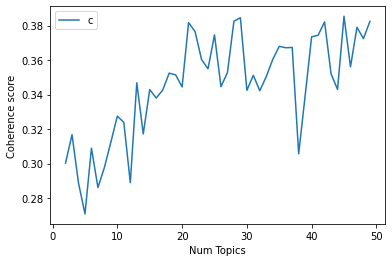

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores


In [23]:
# Print the coherence scores
max_coherence=0
optimal_topics=0
index_model=0
i=0
for m, cv in zip(x, coherence_values):
    if(max_coherence<cv):
        index_model=i
        max_coherence=cv
        optimal_topics=m
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i+=1
    
print("\n_____________________________________________________")   
print(index_model," :: "+"Optimal Topic number =", optimal_topics, " Coherence Scores =", round(max_coherence, 4))

Num Topics = 2  has Coherence Value of 0.3003
Num Topics = 3  has Coherence Value of 0.3168
Num Topics = 4  has Coherence Value of 0.2888
Num Topics = 5  has Coherence Value of 0.2709
Num Topics = 6  has Coherence Value of 0.309
Num Topics = 7  has Coherence Value of 0.2862
Num Topics = 8  has Coherence Value of 0.2978
Num Topics = 9  has Coherence Value of 0.3125
Num Topics = 10  has Coherence Value of 0.3275
Num Topics = 11  has Coherence Value of 0.3239
Num Topics = 12  has Coherence Value of 0.289
Num Topics = 13  has Coherence Value of 0.3468
Num Topics = 14  has Coherence Value of 0.3172
Num Topics = 15  has Coherence Value of 0.3429
Num Topics = 16  has Coherence Value of 0.338
Num Topics = 17  has Coherence Value of 0.3426
Num Topics = 18  has Coherence Value of 0.3524
Num Topics = 19  has Coherence Value of 0.3514
Num Topics = 20  has Coherence Value of 0.3444
Num Topics = 21  has Coherence Value of 0.3817
Num Topics = 22  has Coherence Value of 0.3765
Num Topics = 23  has Coh

In [24]:
# Select the model and print the topics
optimal_model = model_list[index_model]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(17,
  '0.032*"echo" + 0.024*"smart" + 0.023*"voice" + 0.020*"money" + 0.017*"sure" + 0.017*"work" + 0.016*"quality" + 0.016*"control" + 0.015*"home" + 0.014*"product"'),
 (24,
  '0.051*"music" + 0.051*"device" + 0.028*"camera" + 0.023*"setup" + 0.017*"purchase" + 0.016*"nice" + 0.016*"connect" + 0.016*"content" + 0.016*"speech" + 0.016*"basic"'),
 (2,
  '0.045*"time" + 0.023*"love" + 0.023*"thing" + 0.012*"productthere" + 0.012*"company" + 0.012*"wall" + 0.012*"first" + 0.012*"assumption" + 0.012*"beta" + 0.012*"speaker"'),
 (36,
  '0.031*"device" + 0.022*"music" + 0.018*"regular" + 0.018*"package" + 0.018*"sound" + 0.018*"home" + 0.018*"look" + 0.018*"time" + 0.017*"great" + 0.017*"screen"'),
 (7,
  '0.020*"time" + 0.016*"disappointed" + 0.014*"productthere" + 0.012*"half" + 0.011*"couple" + 0.011*"switch" + 0.011*"stage" + 0.011*"item" + 0.010*"natural" + 0.010*"true"'),
 (30,
  '0.042*"adapter" + 0.024*"thing" + 0.021*"enough" + 0.021*"beautiful" + 0.021*"hope" + 0.021*"dollar" + 

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.098216 -0.118223       1        1  5.225976
42    -0.109144  0.013542       2        1  5.111709
33    -0.161011 -0.031486       3        1  4.476780
26    -0.105766  0.007293       4        1  4.074723
24    -0.077592 -0.059608       5        1  4.016959
31    -0.098599 -0.036639       6        1  3.777999
17    -0.110977  0.076987       7        1  3.329624
1     -0.093750  0.007251       8        1  3.230741
37    -0.118295 -0.052287       9        1  3.224331
13    -0.091895  0.072547      10        1  3.020951
18    -0.017761  0.112403      11        1  3.011311
36    -0.051298  0.022130      12        1  2.978751
2      0.084050 -0.132301      13        1  2.830205
21    -0.041232 -0.001522      14        1  2.697953
25    -0.008353 -0.031324      15        1  2.548391
12     0.047270 -0.057033      16        1  2.507237
38    -0.088761 -0.025302      17        1  2.387504
6     -0.013176  0.010516      18        1  2.275741
35     0.004314 -0.044628      19        1  2.241687
27     0.060725  0.097180      20        1  2.106320
15    -0.073281  0.012336      21        1  2.063339
10    -0.068476  0.037147      22        1  2.028401
14     0.067623  0.042389      23        1  2.016262
40    -0.007848 -0.082610      24        1  1.970126
23    -0.006002  0.079685      25        1  1.964916
8     -0.006579 -0.111378      26        1  1.939236
3      0.051311 -0.045059      27        1  1.938949
19    -0.008649  0.172959      28        1  1.913378
41    -0.008140  0.003680      29        1  1.811757
32     0.064887  0.024624      30        1  1.634500
4     -0.020495  0.077472      31        1  1.623102
29     0.071761 -0.019428      32        1  1.601901
16     0.037094 -0.071047      33        1  1.505877
28    -0.037566 -0.021497      34        1  1.426771
43     0.099927 -0.010715      35        1  1.349849
44     0.055498 -0.081460      36        1  1.227565
5      0.012302 -0.015091      37        1  1.075142
20     0.077246  0.028648      38        1  1.055040
11     0.156399 -0.054683      39        1  1.003359
9      0.118672  0.044931      40        1  0.892884
30     0.108411  0.067757      41        1  0.777069
39     0.120910  0.000139      42        1  0.718775
22     0.028756  0.088577      43        1  0.676331
34     0.113715  0.035276      44        1  0.585053
7      0.141988 -0.032149      45        1  0.125523, topic_info=          Term       Freq      Total Category  logprob  loglift
81      device  69.000000  69.000000  Default  30.0000  30.0000
104      music  66.000000  66.000000  Default  29.0000  29.0000
54        time  42.000000  42.000000  Default  28.0000  28.0000
86      screen  29.000000  29.000000  Default  27.0000  27.0000
34       prime  25.000000  25.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
3      builtin   0.003304   1.471819  Topic45  -7.1268   0.5814
4      control   0.003304  18.633865  Topic45  -7.1268  -1.9571
5     customer   0.003304   4.427476  Topic45  -7.1268  -0.5199
6    ecosystem   0.003304   1.473632  Topic45  -7.1268   0.5802
7      garbage   0.003304   1.473663  Topic45  -7.1268   0.5802

[2061 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
294      29  0.673644   1030pm
742       6  0.658377    24ghz
613      29  0.673651    342nd
844      38  0.659355    34hmm
97       24  0.447945     34im
...     ...       ...      ...
307      27  0.133143  youtube
307      36  0.133143  youtube
24        7  0.679409   zigbee
563       2  0.686084    zwave
370      31  0.728713     zzzz

[2328 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 43, 34, 27, 25, 32, 18, 2, 38, 14, 19, 37, 3, 22, 26, 13, 39, 7, 36, 28, 16, 11, 15, 41, 24, 9, 4, 20, 42, 33, 5, 30, 17, 29, 44, 45, 6, 21, 12, 10, 

#### Predict new review using trained model

In [26]:
# Enter customer review
input_review="I was a little nervous when I received my new Echo as I'm not really Tech savvy. I found it a bit intimidating at first but it didn't take me to long to figure it out!! I'm very happy with my purchase and now thinking of adding an echo spot!!!"

In [27]:
# Predicting the topic distribution for the given review
input_testing_review_list=[""]
input_testing_review_list[0]=input_review
tokenized_testing_reviews = lemmatization(input_testing_review_list)
# print(tokenized_testing_reviews[0])

# Tokenized_testing_reviews
new_doc_bow = dictionary.doc2bow(tokenized_testing_reviews[0])
predict_list=lda_model.get_document_topics(new_doc_bow)
predict_list

[(1, 0.111648284), (18, 0.7942296)]

In [28]:
# Finding predict topic
predict_topic_id=0
predict_probability=0

for topic in predict_list:
    if(predict_probability<topic[1]):
        predict_topic_id=topic[0]
        predict_probability=topic[1]
        
#Topic_id ,Probability
print("Topic_id =",predict_topic_id,"  Probability =",predict_probability)

Topic_id = 18   Probability = 0.7942296


In [29]:
x=lda_model.show_topics(num_topics=num_topics, num_words=25,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    if(topic==predict_topic_id):
        topic_terms=" ".join(topics_words[predict_topic_id][1])
        
print("*********************************")
print(topic_terms)

*********************************
alarm echo sound product prime regular nice screen device turn news thing application money light good clock music great work snooze morning spot disappointed time


#### Automatic labeling of LDA generated topics

In [30]:
# !pip install cssselect
# !pip install lxml

In [31]:
from urllib.parse import urlencode, urlparse, parse_qs
from lxml.html import fromstring
from requests import get
from collections import Counter
import re


def get_srp_text(search_term):
    raw = get(f"https://www.google.com/search?q={search_term}").text
    page = fromstring(raw)

    blob = ""
    for result in page.cssselect("a"):
        for res in result.findall("div"):
            blob += ' '
            blob += res.text if res.text else " "
            blob += ' '
    return blob


def blob_cleaner(blob):
    clean_blob = blob.replace(r'[\/,\(,\),\:,_,-,\-]', ' ')
    return ''.join(e for e in blob if e.isalnum() or e.isspace())


def get_name_from_srp_blob(clean_blob):
    blob_tokens = list(filter(bool, map(lambda x: x if len(x) > 2 else '', clean_blob.split(' '))))
    c = Counter(blob_tokens)
    most_common = c.most_common(10)
    
    return_name=[]
    for n in most_common:
        scores=re.findall('[A-Z][^A-Z]*', n[0])
        filtered = filter(lambda score:len(score) > 1, scores)
        return_name+=list(filtered)
        if(len(scores)==0):
            return_name.append(n[0])
            
    name =" ".join(return_name)
    
    return name

pipeline = lambda x: get_name_from_srp_blob(blob_cleaner(get_srp_text(x)))

In [32]:
topic_label = pipeline(topic_terms)
print(topic_label)

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)


wwwcnbccom wwwamazonin Echo Spot Stylishscreen Black wwwcnetcom reviews amazonechoshow5smartdisplay2019review wwwamazoncom help customer display


In [35]:
#join all words in topics 
topic_terms_list=[]

for j in range(0,num_topics):
    topic_terms=" ".join(topics_words[j][1])
    topic_terms_list.append(topic_terms)
    

#### Find all topics labels

In [36]:
# find all topic labels
topic_label_list_all=[]
for t in topic_terms_list:
    topic_label_list_all.append(pipeline(t))

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.P

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.PROTOCOL_SSLv23)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connection.py:374: DeprecationWarning: ssl.match_hostname() is deprecated
  match_hostname(cert, asserted_hostname)
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\util\ssl_.py:262: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = SSLContext(ssl_version or ssl.P

In [37]:
# Printing all labels
for (i, item) in enumerate(topic_label_list_all, start=1):
    print("Topic",i,"::",item)

Topic 1 :: wwwamazoncom Home Automation Modules Zigbee Devices keywo Zigbee Gateway Compatible Detector Controller Compatible Control Automation Wireless Control Transmitter Requires Compatible Smart Thingsdistribu zigbeedevices kzigbeedevices Vcompatible Smart Things Lightify Automat
Topic 2 :: wwwamazonin help customer display encommunitysonoscom amazonalexaandsonos229102 2issueswi colabresearchgooglecom drive wwwkagglecom
Topic 3 :: Smart Home wwwamazoncom Bedroom Activated Changing Controlled Decoration wwwamazoncouk Govee Wireless Controlled Lighting Assistant wwwpcmagcom Best Products wwwtheambientcom
Topic 4 :: wwwamazoncom Echo Dot Amazon Tap Portable Wireless Bluetooth Speakerwi smarthomedevices Portable Battery Rechargeable15600m Ah Included alexamultiroomaudio wwwamazonin Echo Input Portable Smart Speaker wwwnytimescom Electronics
Topic 5 :: booksgooglelk books help customer display wwwamazonin wwwamazoncom kbiuedu aodb wwwsmarthomepointcom
Topic 6 :: blog obkiocom commonnet